In [1]:
import pickle
import numpy as np
import lightgbm as lgb
from scipy.sparse import csr_matrix, save_npz, load_npz

In [2]:
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# Load sparse matrixes and labels

In [3]:
train = load_npz("train_gender.npz")
valid = load_npz("valid_gender.npz")
test = load_npz("test_gender.npz")

In [5]:
with open("data\\train_labels.txt","r") as f:
    train_labels = f.read().split(",")
with open("data\\valid_labels.txt","r") as f:
    valid_labels = f.read().split(",")
with open("data\\test_labels.txt","r") as f:
    test_labels = f.read().split(",")

In [6]:
with open("data\\features_dict_gender.pkl","rb") as f:
    columns = list(pickle.load(f).keys())

# Create lgbm Dataset

In [7]:
train_data = lgb.Dataset(train,   label=train_labels, feature_name=columns)
valid_data = lgb.Dataset(valid,   label=valid_labels, feature_name=columns)
test_data  = lgb.Dataset(test,    label=test_labels , feature_name=columns)

# Lgbm params

In [8]:
param = {'boosting':'gbdt',
         'objective':'multiclass',
         'num_threads':35,
         'num_class':2,
         "learning_rate": 0.05,
         "num_leaves": 6,
         "max_depth": 6,
         "feature_fraction": 0.4,
         "bagging_fraction": 0.3,
         "reg_alpha": 0.15,
         "reg_lambda": 0.15}
param['metric'] = ['multi_error']

# Train

In [9]:
bst = lgb.train(param, train_data, 500,
                valid_sets=[valid_data])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.627892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78343
[LightGBM] [Info] Number of data points in the train set: 3268972, number of used features: 770
[LightGBM] [Info] Start training from score -0.628180
[LightGBM] [Info] Start training from score -0.762630
[1]	valid_0's multi_error: 0.492807
[2]	valid_0's multi_error: 0.451308
[3]	valid_0's multi_error: 0.364502
[4]	valid_0's multi_error: 0.32483
[5]	valid_0's multi_error: 0.308829
[6]	valid_0's multi_error: 0.303008
[7]	valid_0's multi_error: 0.258246
[8]	valid_0's multi_error: 0.261438
[9]	valid_0's multi_error: 0.23526
[10]	valid_0's multi_error: 0.233433
[11]	valid_0's multi_error: 0.22028
[12]	valid_0's multi_error: 0.224561
[13]	valid_0's multi_error: 0.227821
[14]	valid_0's multi_error: 0.215277
[15]	valid_0's multi_error

# Evaluate

In [13]:
preds = bst.predict(test)
preds_id = np.argmax(preds, axis=1)

In [14]:
preds_id = np.argmax(preds, axis=1)

In [15]:
labels_int = [int(i) for i in test_labels]

In [16]:
print(classification_report(labels_int , preds_id, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84    217991
           1       0.87      0.87      0.87    264120

    accuracy                           0.86    482111
   macro avg       0.86      0.86      0.86    482111
weighted avg       0.86      0.86      0.86    482111



No Skill: ROC AUC=0.500
LGBM: ROC AUC=0.857


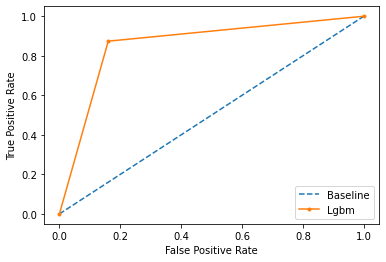

In [17]:
ns_probs = [0 for _ in range(len(labels_int))]
ns_auc = roc_auc_score(labels_int, ns_probs)
lgbm_auc = roc_auc_score(labels_int, preds_id)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(labels_int, ns_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(labels_int, preds_id)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
pyplot.plot(lgbm_fpr, lgbm_tpr, marker='.', label='Lgbm')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [55]:
bst.save_model("gender_model_auc_{}.txt".format(str(lgbm_auc)))